In [243]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


## 📚 Importing Necessary Libraries

In [244]:
# Essential libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

# Handling class imbalance
from imblearn.combine import SMOTEENN

# Machine learning models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Hyperparameter tuning distributions
from scipy.stats import randint as sp_randint, uniform as sp_uniform

# Evaluation metrics
from sklearn.metrics import f1_score, accuracy_score

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 🗂️ Loading the Dataset


In [245]:
# Load the dataset
train_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

In [246]:
print("Train Data Preview:")
display(train_data.head(10))

Train Data Preview:


,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no
5,2009-05-07,25,entrepreneur,single,tertiary,no,140,yes,no,cellular,348,1,-1,0,NaN,no
6,2009-05-15,46,blue-collar,married,secondary,no,668,yes,no,NaN,1263,2,-1,0,NaN,yes
7,2010-05-08,37,admin.,married,secondary,no,14,yes,no,NaN,176,2,-1,0,NaN,no
8,2008-12-13,38,unemployed,divorced,primary,yes,14123,yes,yes,cellular,2370,4,852,4,other,no
9,2010-05-21,31,technician,married,secondary,no,589,yes,yes,NaN,151,1,-1,0,NaN,no


In [247]:
train_data.shape

(39211, 16)

## 📊 Exploratory Data Analysis (EDA)


##  Statistical Summary


In [248]:
print("\nTrain Data Description:")
print(train_data.describe())


Train Data Description:
                age        balance      duration      campaign         pdays  \
count  39211.000000   39211.000000  39211.000000  39211.000000  39211.000000   
mean      42.120247    5441.781719    439.062789      5.108770     72.256051   
std       12.709352   16365.292065    769.096291      9.890153    160.942593   
min       18.000000   -8019.000000      0.000000      1.000000     -1.000000   
25%       33.000000      98.000000    109.000000      1.000000     -1.000000   
50%       40.000000     549.000000    197.000000      2.000000     -1.000000   
75%       50.000000    2030.000000    380.000000      4.000000     -1.000000   
max       95.000000  102127.000000   4918.000000     63.000000    871.000000   

           previous  
count  39211.000000  
mean      11.826171  
std       44.140259  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


## 📝 Dataset Information

In [249]:
print("\nTrain Data Info:")
train_data.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10

Numerical Feature Summary Statistics:
                 age        balance      duration      campaign         pdays  \
count  39211.000000   39211.000000  39211.000000  39211.000000  39211.000000   
mean      42.120247    5441.781719    439.062789      5.108770     72.256051   
std       12.709352   16365.292065    769.096291      9.890153    160.942593   
min       18.000000   -8019.000000      0.000000      1.000000     -1.000000   
25%       33.000000      98.000000    109.000000      1.000000     -1.000000   
50%       40.000000     549.000000    197.000000      2.000000     -1.000000   
75%       50.000000    2030.000000    380.000000      4.000000     -1.000000   
max       95.000000  102127.000000   4918.000000     63.000000    871.000000   

           previous  
count  39211.000000  
mean      11.826171  
std       44.140259  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


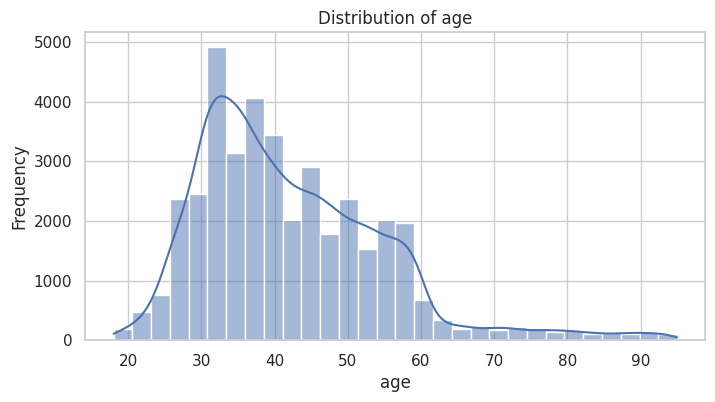

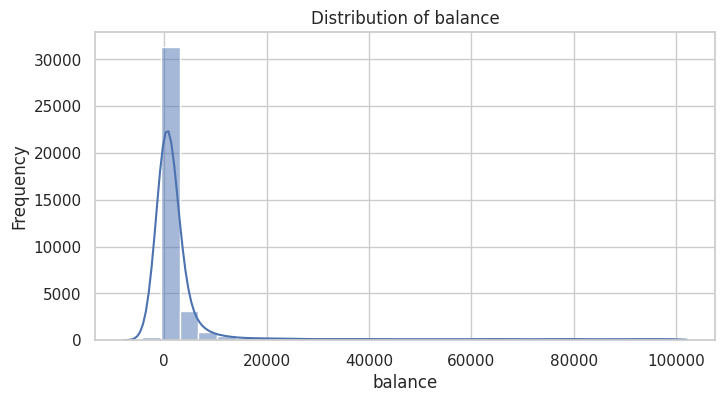

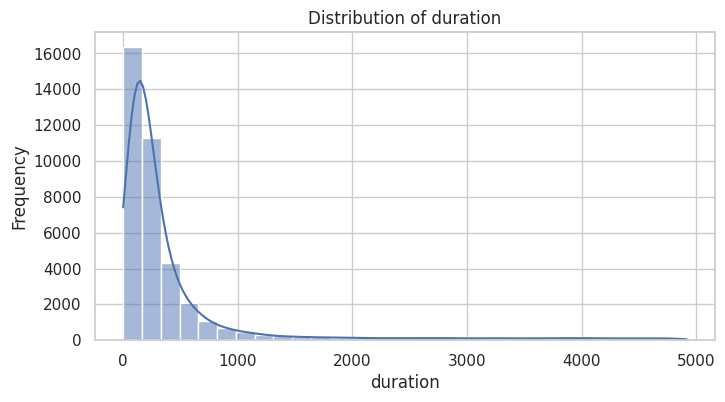

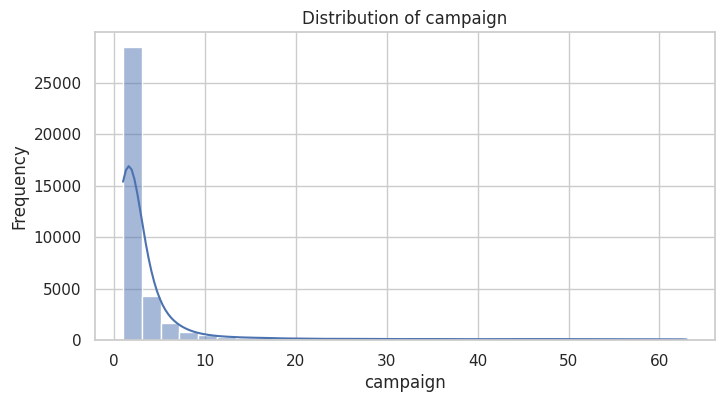

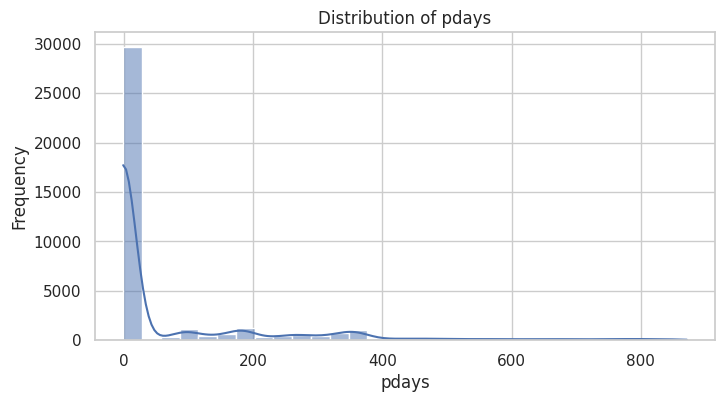

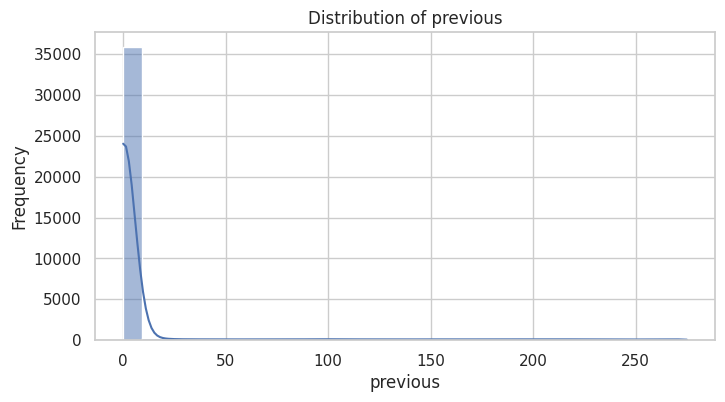

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Separate numerical and categorical columns
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# 1. Numerical Features Analysis
print("Numerical Feature Summary Statistics:\n", train_data[numerical_features].describe())

# Plot histograms for each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_data[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

### Insights from Numerical Features

- **Age**: Distribution peaks around 30-50, indicating most clients are middle-aged.
- **Balance**: Highly right-skewed, with many clients having low or negative balances; a few have very high balances (potential outliers).
- **Duration**: Mostly short interactions with a right tail, showing some lengthy calls.
- **Campaign**: Right-skewed, most clients contacted a few times; fewer clients contacted many times, suggesting possible resistance.
- **Pdays**: Primarily -1, meaning no prior contact; values for prior contacts are centered around 200.
- **Previous**: Sharp peak at zero (no prior contacts), with a few clients having repeated contacts.


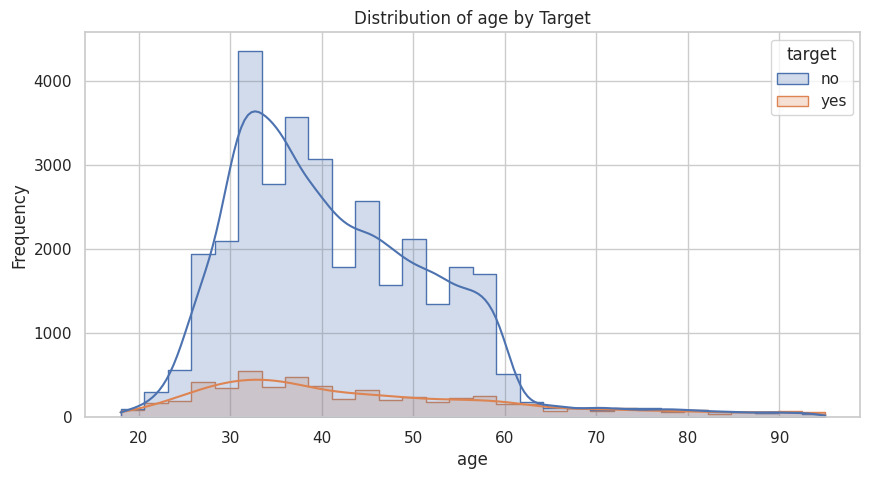

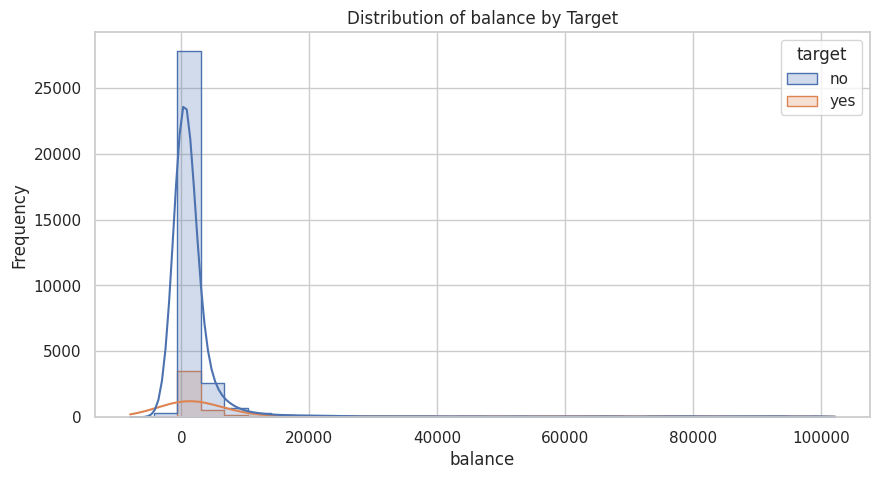

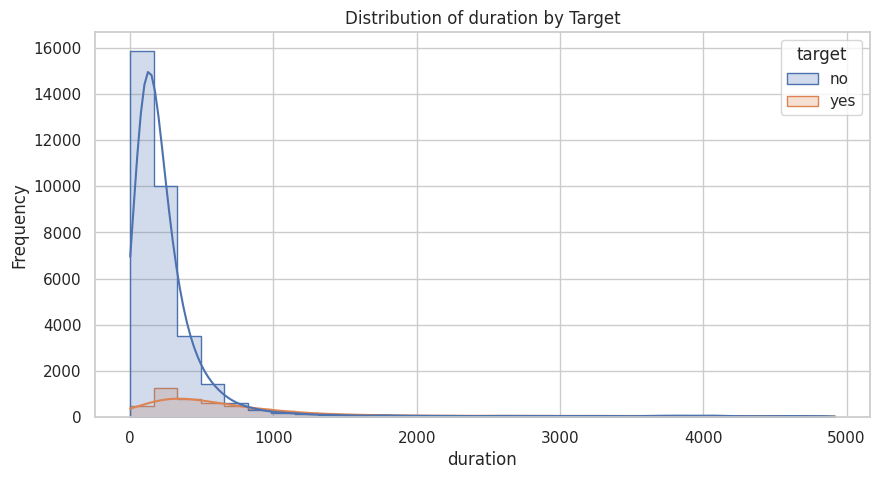

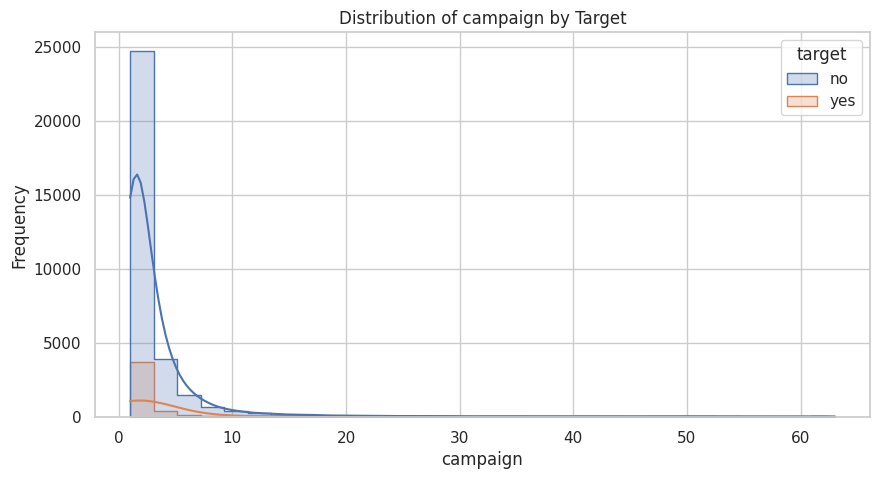

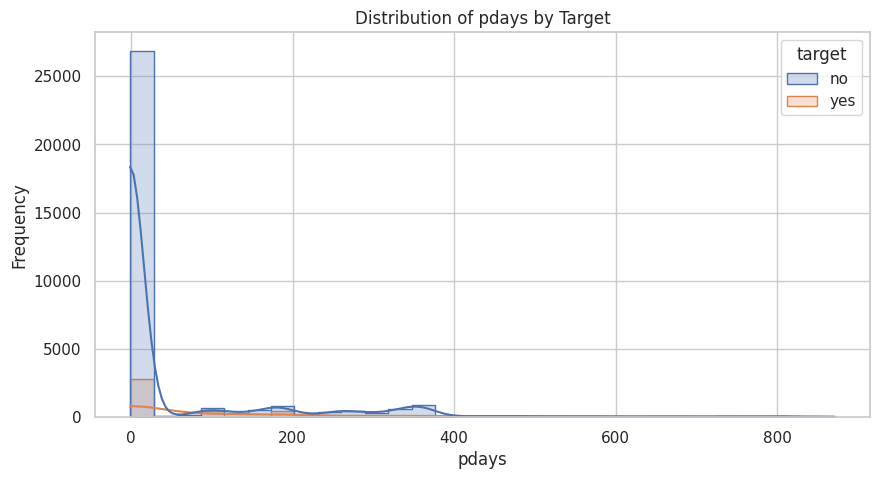

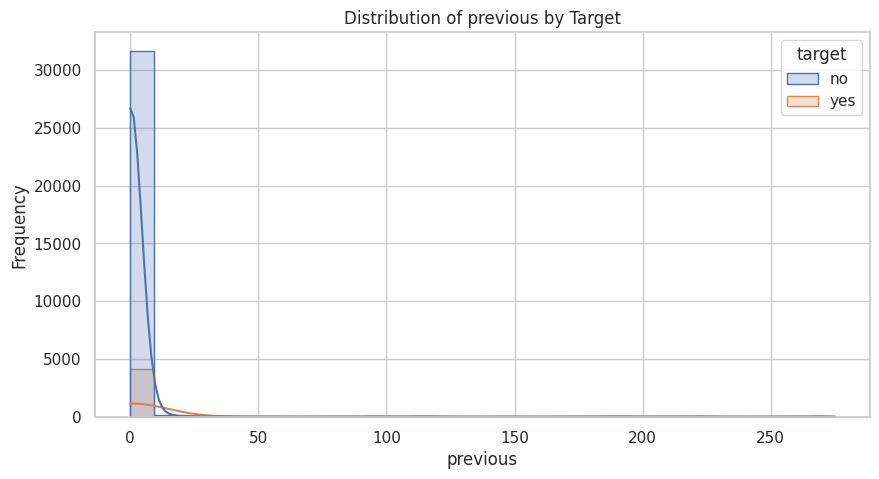

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for consistency
sns.set(style="whitegrid")

# Plot the distribution of each numerical feature by target
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=train_data, x=feature, hue='target', kde=True, bins=30, element='step')
    plt.title(f"Distribution of {feature} by Target")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


### Key Findings by Target Group

- **Balance**: Higher balances are more common in one target group, indicating a possible link to positive responses.
- **Duration**: Longer interaction durations tend to correlate with positive responsps.


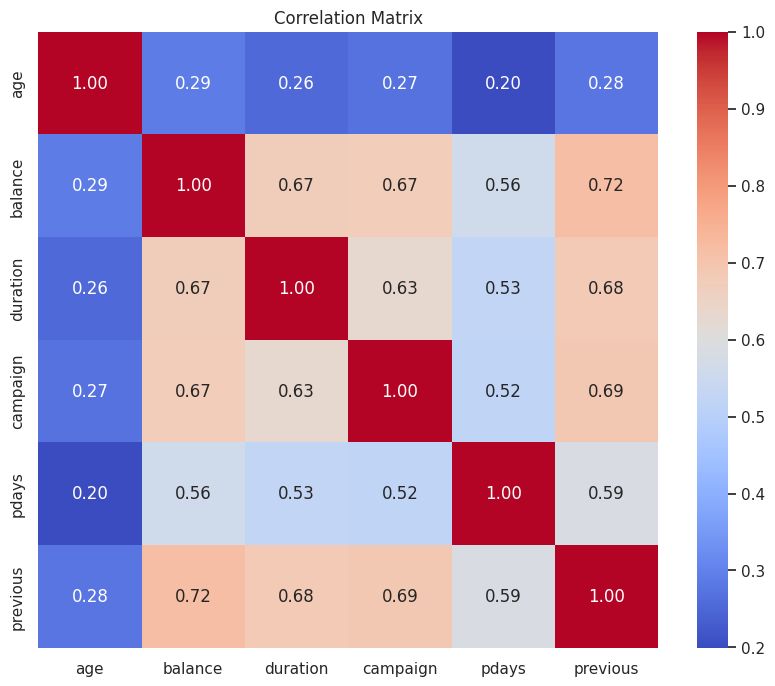

In [252]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Correlation Matrix Insights

- **Age and Balance**: Low positive correlation, suggesting that older clients may have slightly higher balances.
- **Duration and Campaign**: Minimal correlation with other features, indicating they are relatively independent.
- **Pdays and Previous**: Moderate positive correlation, likely because previous contacts are often associated with a recorded `pdays` vaarity.


last contact date has 1013 unique values


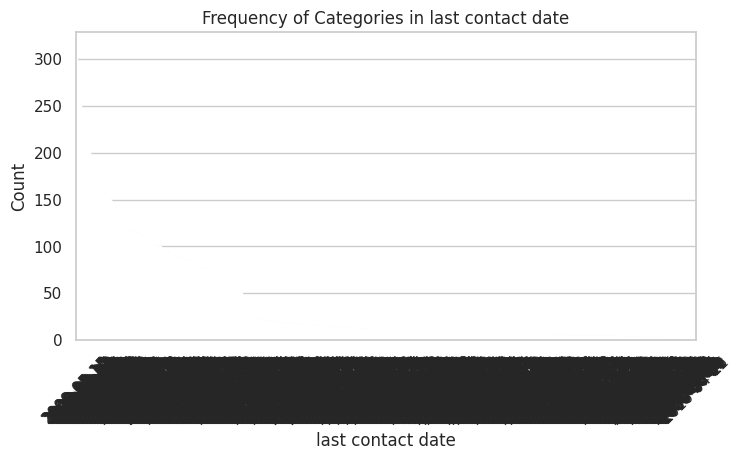

job has 11 unique values


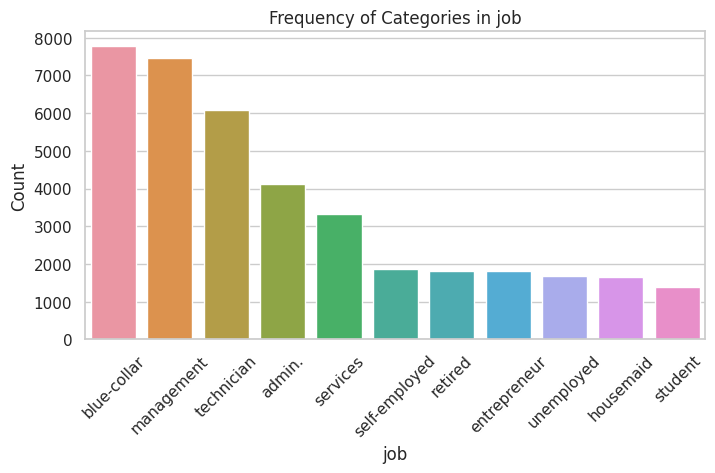

marital has 3 unique values


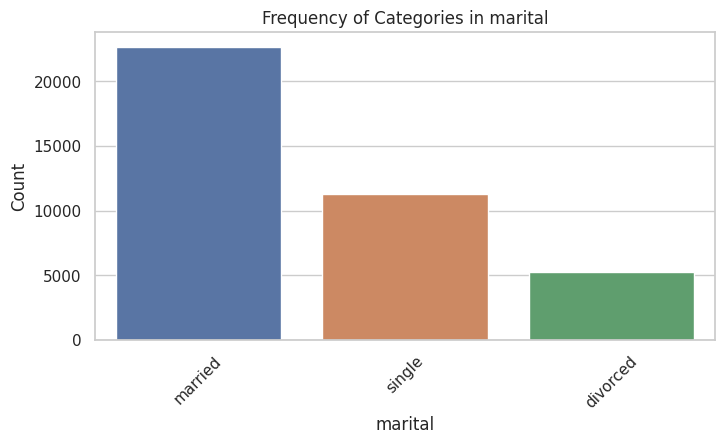

education has 3 unique values


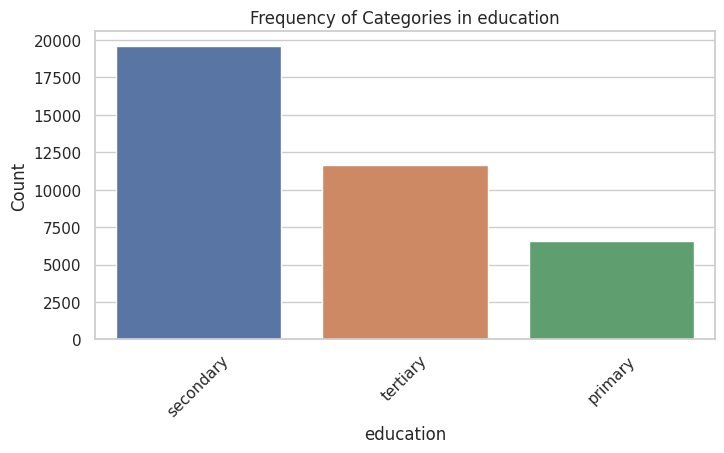

default has 2 unique values


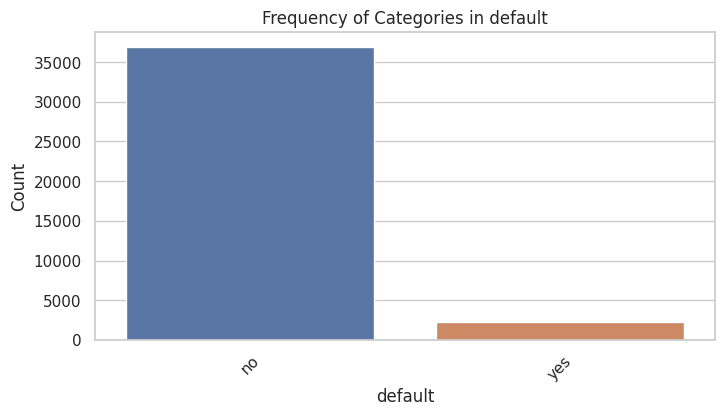

housing has 2 unique values


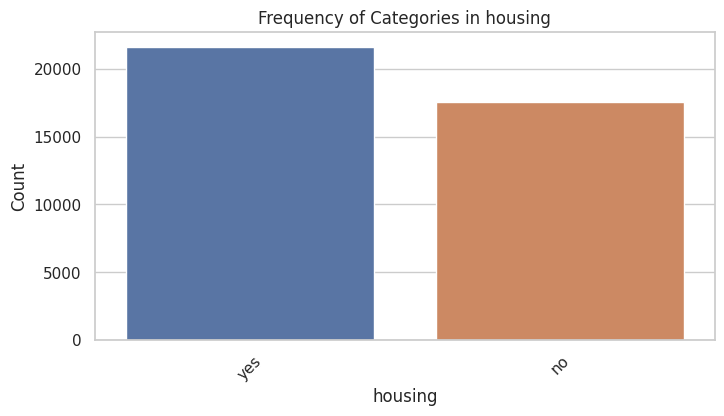

loan has 2 unique values


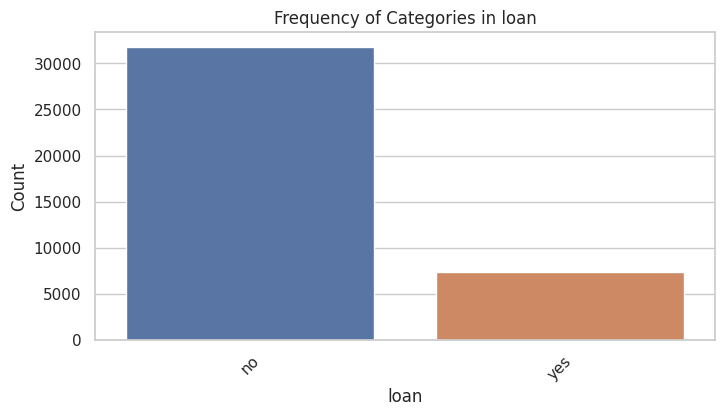

contact has 2 unique values


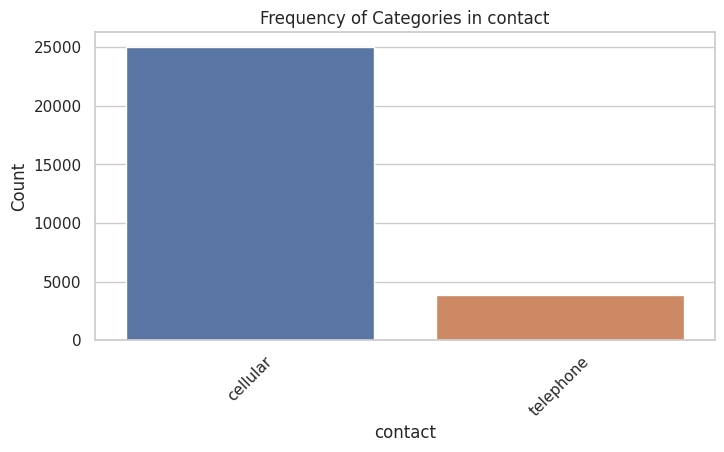

poutcome has 3 unique values


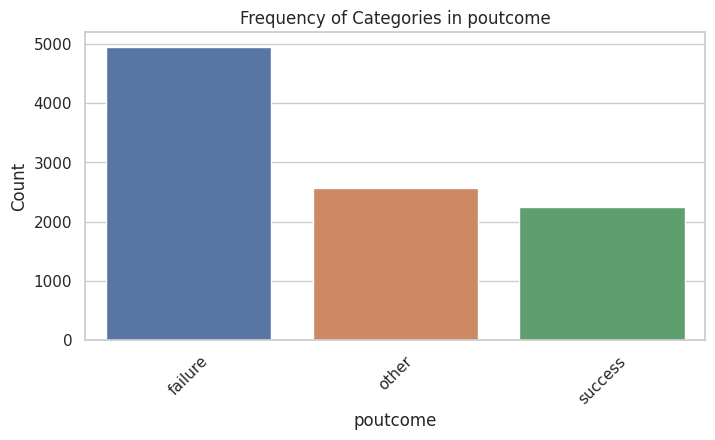

target has 2 unique values


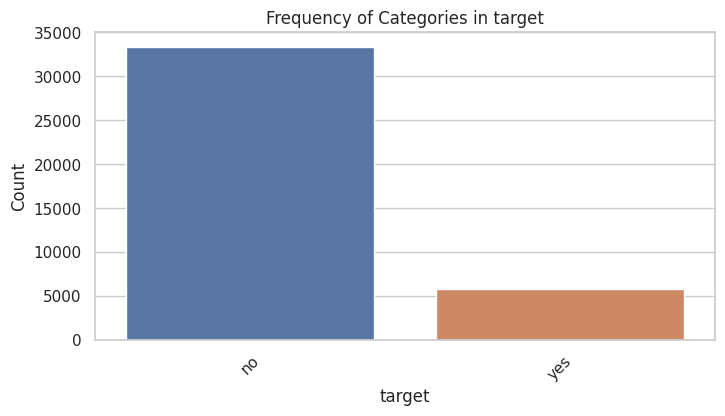

In [253]:
# 2. Categorical Features Analysis
for feature in categorical_features:
    unique_values = train_data[feature].nunique()
    print(f"{feature} has {unique_values} unique values")

    # Plot the count of each category
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_data, x=feature, order=train_data[feature].value_counts().index)
    plt.title(f"Frequency of Categories in {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

### Categorical Features Summary
**High Cardinality**: 
  - **Last Contact Date**: Contains 1,013 unique values, which may require further processing due to its high cardinality.

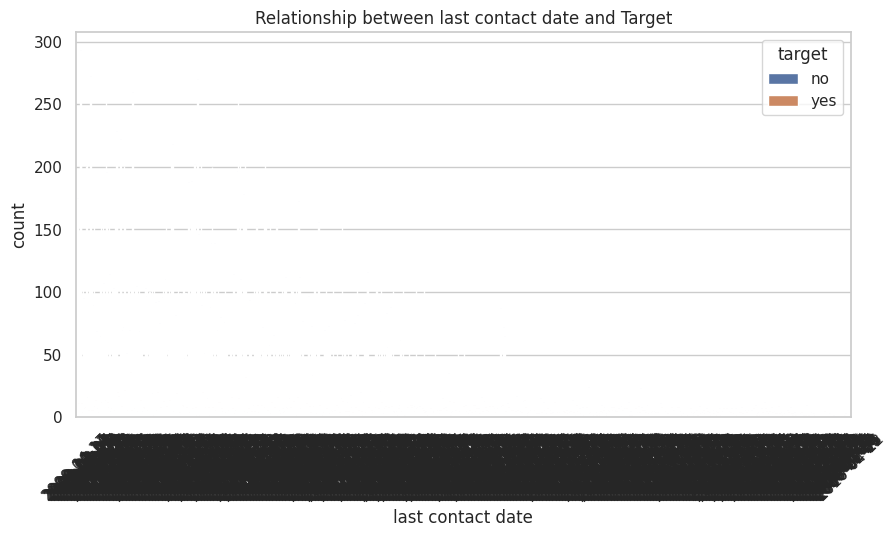

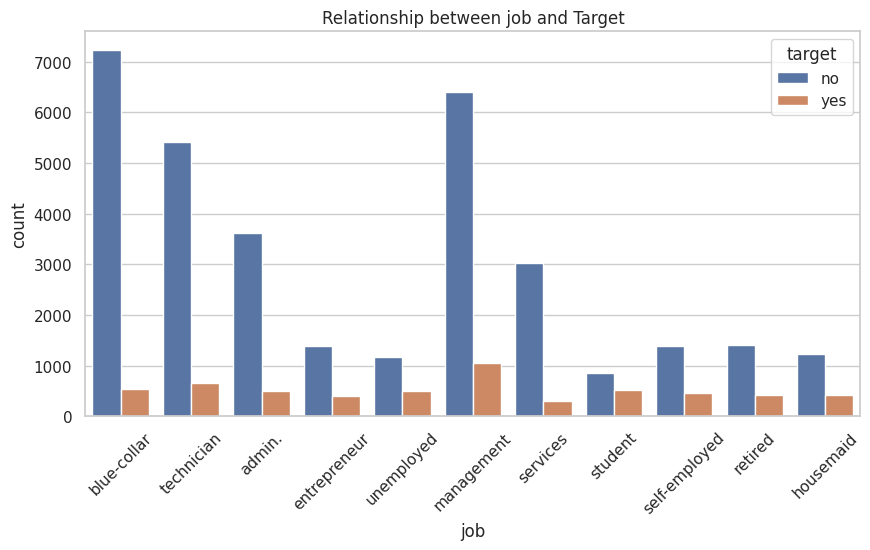

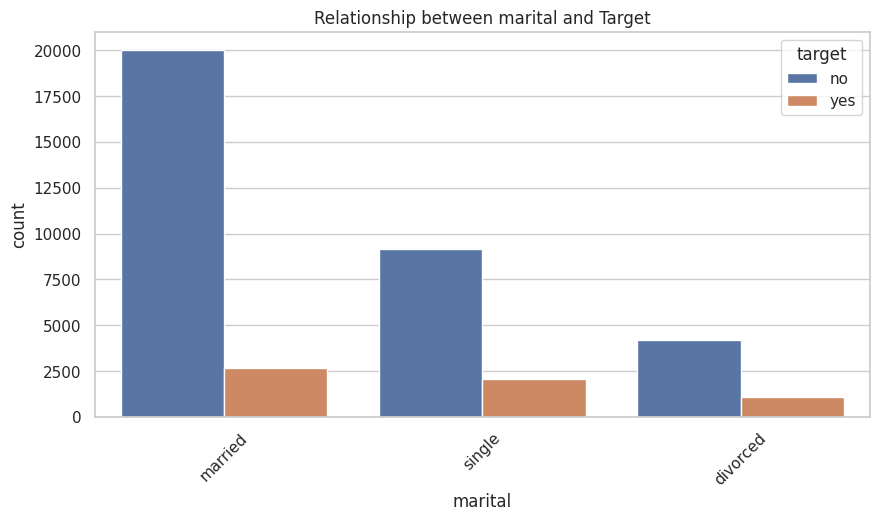

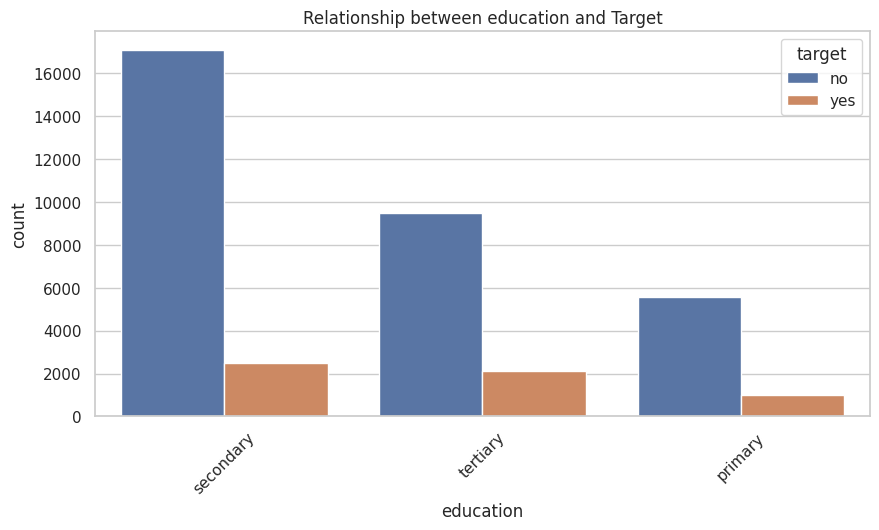

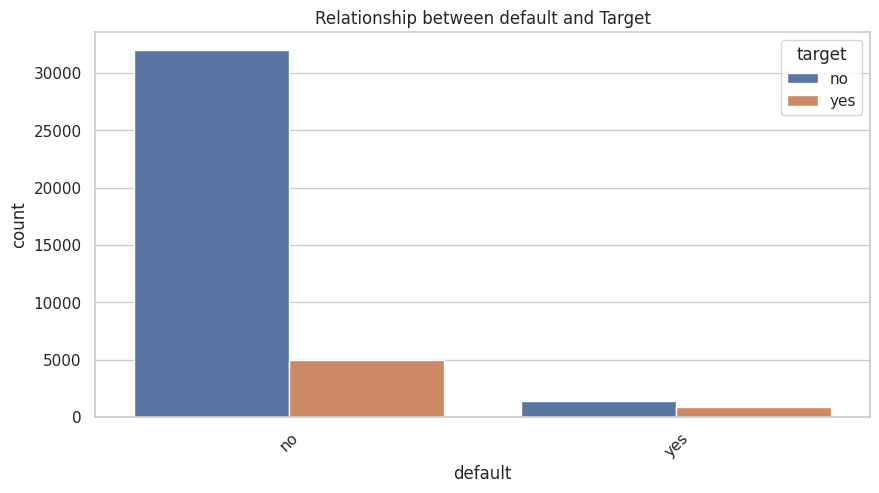

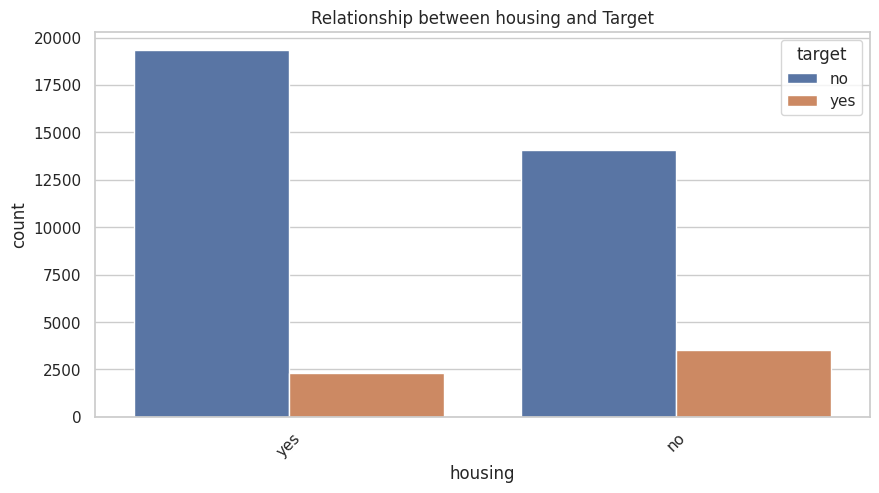

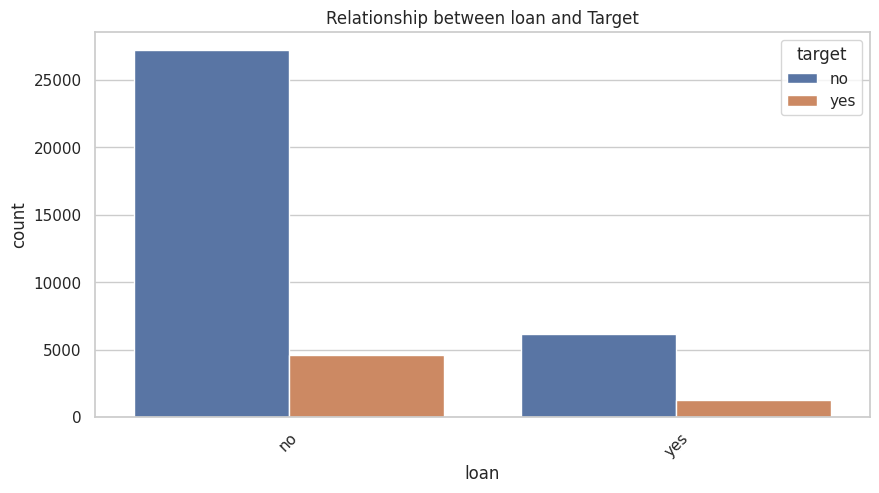

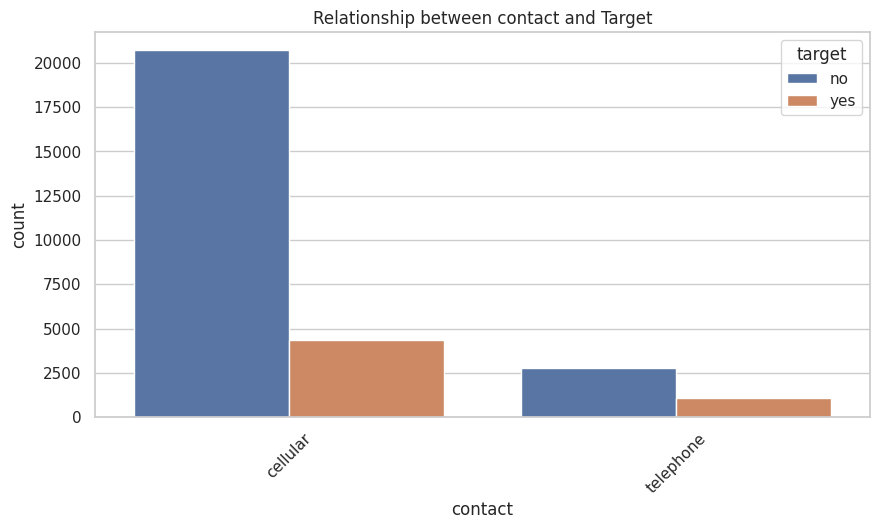

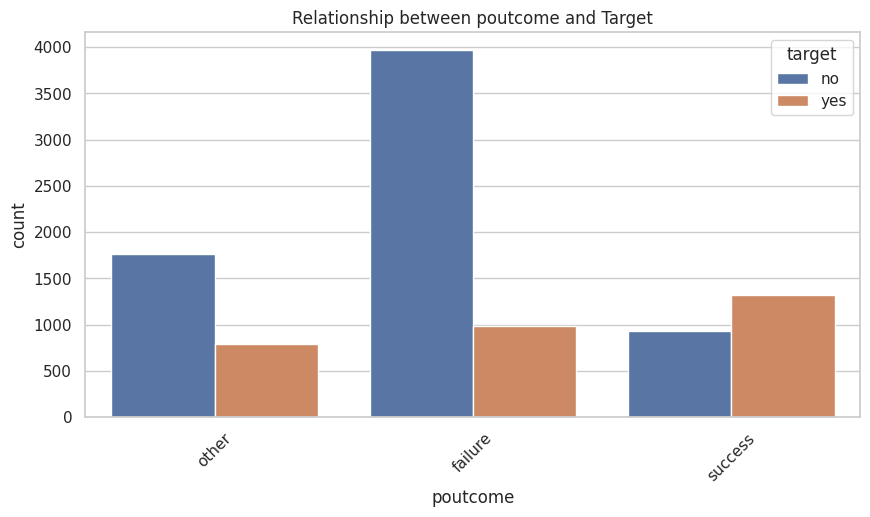

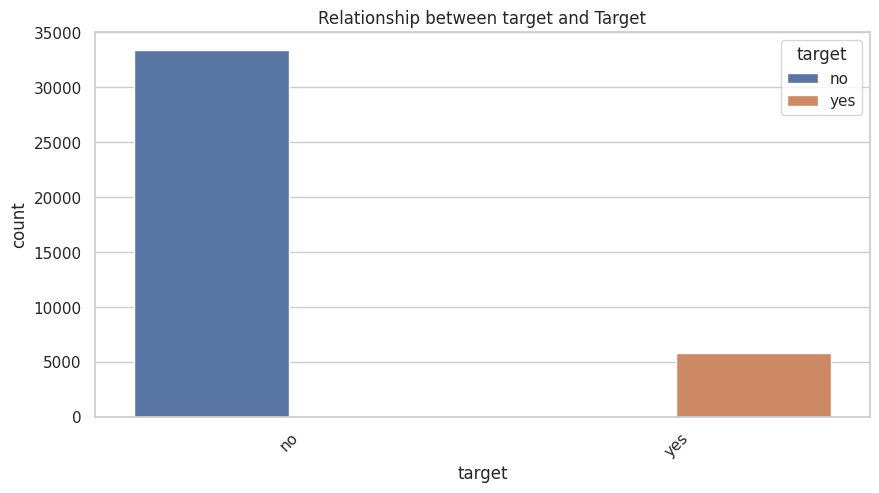

In [254]:
# Plot relationship between categorical features and target
for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=train_data, x=col, hue='target')
    plt.title(f"Relationship between {col} and Target")
    plt.xticks(rotation=45)
    plt.show()

### Key Insights on Categorical Features and Target Outcome

- **Client Profile (Job, Marital, Education)**: Certain job roles, marital statuses, and education levels show higher rates of positive responses, suggesting these profiles may be more receptive to telemarketing.

- **Financial Flexibility (Default, Housing, Loan)**: Clients without prior defaults or loans (housing or personal) tend to respond more positively, indicating financial stability may influence willingness to subscribe.

- **Previous Interaction (Contact, Poutcome)**: Contact type and outcome of previous campaigns show patterns where specific contact methods and prior positive outcomes correlate with higher engagement.

- **Last Contact Date**: This feature shows varied responses, indicating that additional processing, like extracting time-based patterns, may enhance its predictivesponses.


## 🔄 Data Preprocessing

## 🚨 Missing Values Analysis


In [255]:
# Calculate missing values and their percentage
missing_data = train_data.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(train_data)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

print("Missing Values and Percentage:")
print(missing_info)

Missing Values and Percentage:
                   Missing Values  Percentage
poutcome                    29451   75.109026
contact                     10336   26.359950
education                    1467    3.741297
job                           229    0.584020
last contact date               0    0.000000
age                             0    0.000000
marital                         0    0.000000
default                         0    0.000000
balance                         0    0.000000
housing                         0    0.000000
loan                            0    0.000000
duration                        0    0.000000
campaign                        0    0.000000
pdays                           0    0.000000
previous                        0    0.000000
target                          0    0.000000


In [256]:
# Impute missing values for categorical columns with a placeholder 'Unknown'
for col in ['job', 'education', 'contact', 'poutcome']:
    train_data[col] = train_data[col].fillna('Unknown')

In [257]:
# Calculate missing values and their percentage
missing_data = train_data.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(train_data)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

print("Missing Values and Percentage:")
print(missing_info)

Missing Values and Percentage:
                   Missing Values  Percentage
last contact date               0         0.0
age                             0         0.0
job                             0         0.0
marital                         0         0.0
education                       0         0.0
default                         0         0.0
balance                         0         0.0
housing                         0         0.0
loan                            0         0.0
contact                         0         0.0
duration                        0         0.0
campaign                        0         0.0
pdays                           0         0.0
previous                        0         0.0
poutcome                        0         0.0
target                          0         0.0


# Handling Outliers

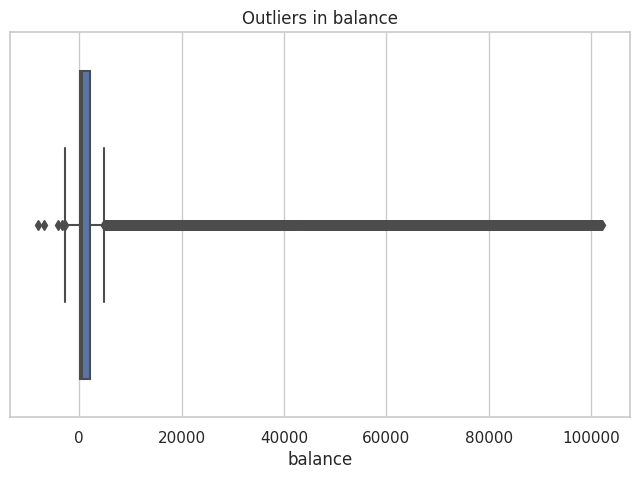

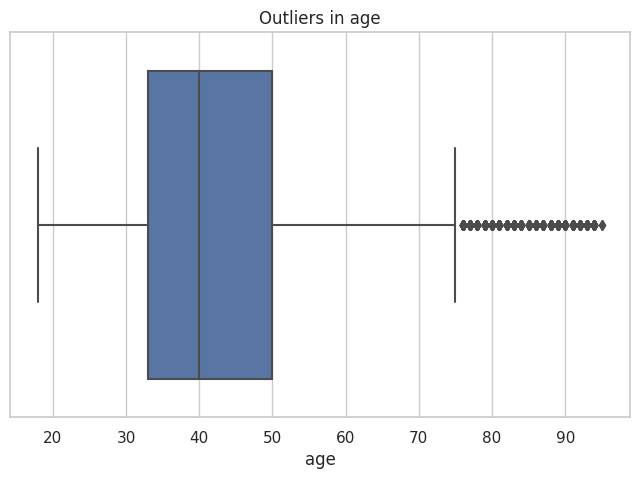

In [258]:
# Box plots for selected numerical features
for col in ['balance', 'age']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_data, x=col)
    plt.title(f"Outliers in {col}")
    plt.show()

In [259]:
import pandas as pd

# Calculate the IQR and thresholds for 'balance'
Q1_balance = train_data['balance'].quantile(0.25)
Q3_balance = train_data['balance'].quantile(0.75)
IQR_balance = Q3_balance - Q1_balance
cap_upper_balance = Q3_balance + 1.5 * IQR_balance
cap_lower_balance = Q1_balance - 1.5 * IQR_balance

# Calculate the IQR and thresholds for 'age'
Q1_age = train_data['age'].quantile(0.25)
Q3_age = train_data['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
cap_upper_age = Q3_age + 1.5 * IQR_age
cap_lower_age = Q1_age - 1.5 * IQR_age

# Cap the outliers in 'balance' and 'age'
train_data['balance'] = train_data['balance'].apply(lambda x: cap_upper_balance if x > cap_upper_balance else (cap_lower_balance if x < cap_lower_balance else x))
train_data['age'] = train_data['age'].apply(lambda x: cap_upper_age if x > cap_upper_age else (cap_lower_age if x < cap_lower_age else x))

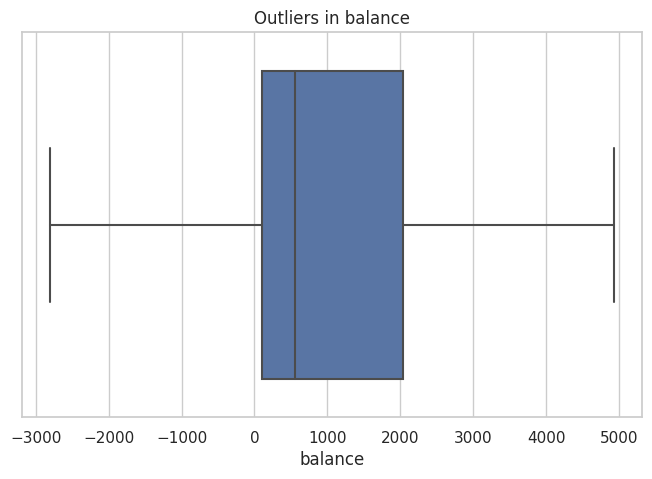

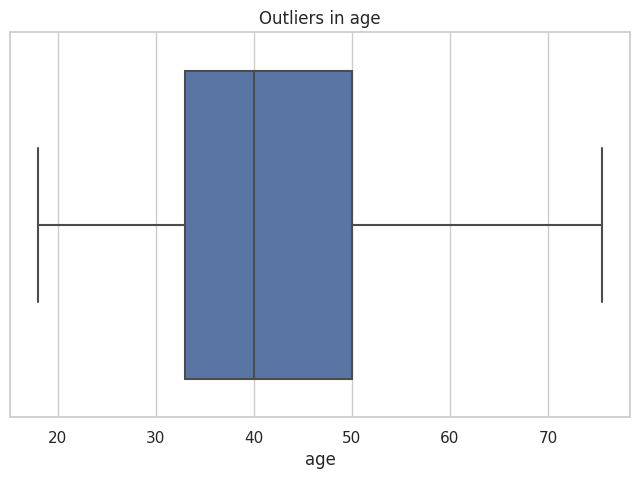

In [260]:
# Box plots for selected numerical features
for col in ['balance', 'age']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_data, x=col)
    plt.title(f"Outliers in {col}")
    plt.show()

In [261]:
# Display unique counts for numerical features
#unique_counts = train_data.select_dtypes(include=['float64', 'int64']).nunique()
#print("Unique counts for numerical features:\n", unique_counts)


In [262]:
# Apply log transformation to Balance
#train_data['balance'] = np.log1p(train_data['balance'] - train_data['balance'].min() + 1)

# Display the transformed Balance feature to verify changes
#train_data['balance'].head()


In [263]:
# Apply log transformation to Duration
#train_data['duration'] = np.log1p(train_data['duration'])

# Display the transformed Duration feature to verify changes
#train_data['duration'].head()


In [264]:
# Apply log transformation to Campaign
#train_data['campaign'] = np.log1p(train_data['campaign'])

# Display the transformed Campaign feature to verify changes
#train_data['campaign'].head()


# Feature Engineering

In [265]:
test_data['last contact date'] = pd.to_datetime(test_data['last contact date'])
test_data['contact_year'] = test_data['last contact date'].dt.year
test_data['contact_month'] = test_data['last contact date'].dt.month
test_data['contact_day'] = test_data['last contact date'].dt.day
test_data['contact_dayofweek'] = test_data['last contact date'].dt.dayofweek

In [266]:
train_data.drop('last contact date', axis=1, inplace=True)
test_data.drop('last contact date', axis=1, inplace=True)

In [267]:
for col in ['job', 'education', 'contact', 'poutcome']:
    test_data[col] = test_data[col].fillna('Unknown')

### Encoding, Alignment, and Scaling of Features


In [268]:
# Encode categorical variables using one-hot encoding
train_data_encoded = pd.get_dummies(train_data, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])
test_data_encoded = pd.get_dummies(test_data, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])

# Align test_data_encoded to train_data_encoded
test_data_encoded = test_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)

# Separate features and target variable
X = train_data_encoded.drop('target', axis=1)
y = train_data_encoded['target'].apply(lambda x: 1 if x == 'yes' else 0)  # Convert target to binary
X_test_final = test_data_encoded.drop('target', axis=1)

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)

In [269]:
# Address class imbalance using SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Models

# Model 1 : Random Forest

In [270]:
# Model 1: Random Forest
param_dist_rf = {
    'n_estimators': sp_randint(100, 200),
    'max_depth': sp_randint(10, 30),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 4)
}

# Initialize and perform Randomized Search for Random Forest
rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, n_iter=20, cv=3, scoring='f1_macro', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)
best_rf = random_search_rf.best_estimator_

# Validate the Random Forest model
best_rf_pred = best_rf.predict(X_valid)
best_rf_f1 = f1_score(y_valid, best_rf_pred, average='macro')
print(f"Random Forest F1 Score: {best_rf_f1}")

Random Forest F1 Score: 0.969838412103379


# Model 2 - XGBoost

In [271]:
#Model 2 : XGBoost

# Define parameter distributions for XGBoost
param_dist_xgb = {
    'n_estimators': sp_randint(100, 200),
    'max_depth': sp_randint(10, 30),
    'learning_rate': sp_uniform(0.01, 0.2),
    'subsample': sp_uniform(0.7, 0.3)
}

# Initialize and perform Randomized Search for XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist_xgb, n_iter=20, cv=3, scoring='f1_macro', n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_

# Ensemble Model: Voting Classifier

voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('xgb', best_xgb)], voting='soft')
voting_clf.fit(X_train, y_train)

best_rf_pred = best_rf.predict(X_valid)
best_xgb_pred = best_xgb.predict(X_valid)
voting_pred = voting_clf.predict(X_valid)

best_rf_f1 = f1_score(y_valid, best_rf_pred, average='macro')
best_xgb_f1 = f1_score(y_valid, best_xgb_pred, average='macro')
voting_f1 = f1_score(y_valid, voting_pred, average='macro')

print(f"Random Forest F1 Score: {best_rf_f1}")
print(f"XGBoost F1 Score: {best_xgb_f1}")

# Predict on the test set
test_predictions = voting_clf.predict(X_test_scaled)

# Convert predictions back to original labels
test_predictions_labels = ['yes' if pred == 1 else 'no' for pred in test_predictions]

Random Forest F1 Score: 0.969838412103379
XGBoost F1 Score: 0.9733460284910194


# Model 3 - Logistic Regression with Pipelining and HyperParameter Tuning

In [272]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

submission_data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')

# Shuffle the dataset to mix positive and negative examples well
train_data = shuffle(train_data, random_state=42)

# Split data into features and target
X = train_data.drop(columns=['target'])
y = train_data['target'].map({'yes': 1, 'no': 0})  # Convert target to binary

# Splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical columns
num_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Define preprocessing for numerical features (impute missing values with median, then scale)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features (impute missing values with 'missing', then one-hot encode)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the numerical and categorical transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Create a pipeline that combines the preprocessor with logistic regression
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

# Define hyperparameter space for Logistic Regression
param_distributions = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2']        # Penalty type
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = random_search.predict(X_val)

# Evaluate the model
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6671
           1       0.58      0.23      0.33      1172

    accuracy                           0.86      7843
   macro avg       0.73      0.60      0.62      7843
weighted avg       0.83      0.86      0.83      7843



# Best of Three Models

In [277]:
# Assuming the F1 scores for the three models
best_model_name = None
best_f1_score = 0
final_best_model = None

# Evaluating the best model among Random Forest, XGBoost, and Logistic Regression
for model, f1 in zip(['Random Forest', 'XGBoost', 'Logistic Regression'], 
                     [best_rf_f1, best_xgb_f1, random_search.best_score_]):
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_name = model
        if model == 'Random Forest':
            final_best_model = best_rf
        elif model == 'XGBoost':
            final_best_model = best_xgb
        elif model == 'Logistic Regression':
            final_best_model = random_search.best_estimator_

print(f"\nBest model: {best_model_name} with F1 Score: {best_f1_score}")

# Predict on the test set with the best model
test_predictions = final_best_model.predict(X_test_scaled)

# Convert predictions back to original labels ('yes' or 'no')
test_predictions_labels = ['yes' if pred == 1 else 'no' for pred in test_predictions]
submission_df=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')


# Create submission file using the sample submission dataframe
submission_df['target'] = test_predictions_labels

# Save the submission dataframe to a CSV file
submission_df.to_csv('submissionx.csv', index=False)

print("Submission file created successfully!")



Best model: XGBoost with F1 Score: 0.9733460284910194
Submission file created successfully!
